In [1]:
pip install scikit-learn==1.4

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,LabelEncoder


from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

from sklearn.model_selection import StratifiedKFold


from sklearn.metrics import accuracy_score, classification_report

### EDA

In [2]:
data=pd.read_csv('data/titanic.csv')
data.head()

,PassengerId,Name,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Survived
0,1,"Braund, Mr. Owen Harris",3,male,22.0,1,0,A/5 21171,7.2500,NaN,S,0
1,2,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,female,38.0,1,0,PC 17599,71.2833,C85,C,1
2,3,"Heikkinen, Miss. Laina",3,female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,1
3,4,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,female,35.0,1,0,113803,53.1000,C123,S,1
4,5,"Allen, Mr. William Henry",3,male,35.0,0,0,373450,8.0500,NaN,S,0


In [3]:
data.shape

(891, 12)

In [4]:
data.size

10692

In [5]:
lb=LabelEncoder()
data['Name']=lb.fit_transform(data['Name'])
data['Sex']=lb.fit_transform(data['Sex'])
data['Ticket']=lb.fit_transform(data['Ticket'])
data['Cabin']=lb.fit_transform(data['Cabin'])
data['Embarked']=lb.fit_transform(data['Embarked'])

In [6]:
data.isna().sum()

PassengerId      0
Name             0
Pclass           0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin            0
Embarked         0
Survived         0
dtype: int64

In [7]:
data['Age']=data['Age'].fillna(data['Age'].mean())

In [8]:
data.isna().sum()

PassengerId    0
Name           0
Pclass         0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Cabin          0
Embarked       0
Survived       0
dtype: int64

In [9]:
data.duplicated().sum()

0

In [10]:
data.dtypes

PassengerId      int64
Name             int32
Pclass           int64
Sex              int32
Age            float64
SibSp            int64
Parch            int64
Ticket           int32
Fare           float64
Cabin            int32
Embarked         int32
Survived         int64
dtype: object

In [11]:
data.head()

,PassengerId,Name,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Survived
0,1,108,3,1,22.0,1,0,523,7.2500,147,2,0
1,2,190,1,0,38.0,1,0,596,71.2833,81,0,1
2,3,353,3,0,26.0,0,0,669,7.9250,147,2,1
3,4,272,1,0,35.0,1,0,49,53.1000,55,2,1
4,5,15,3,1,35.0,0,0,472,8.0500,147,2,0


### Outlier Detection

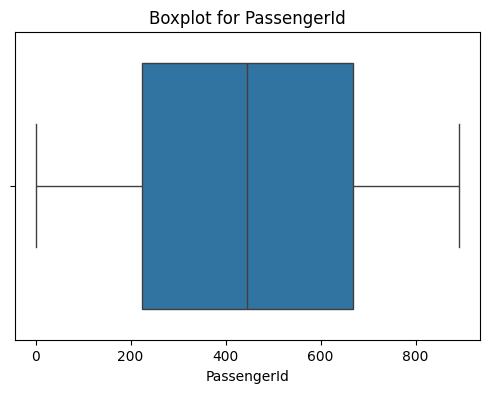

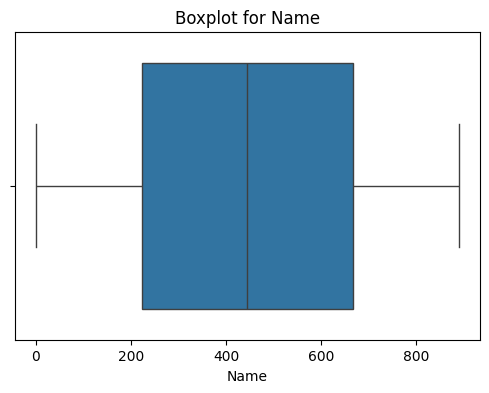

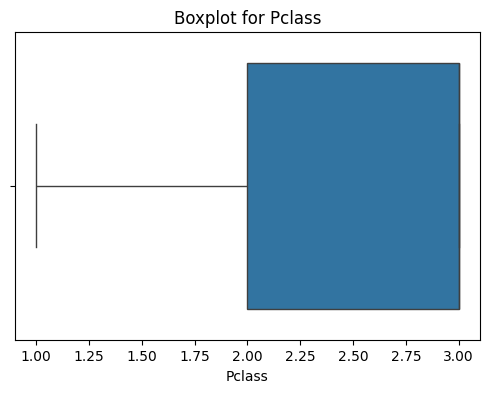

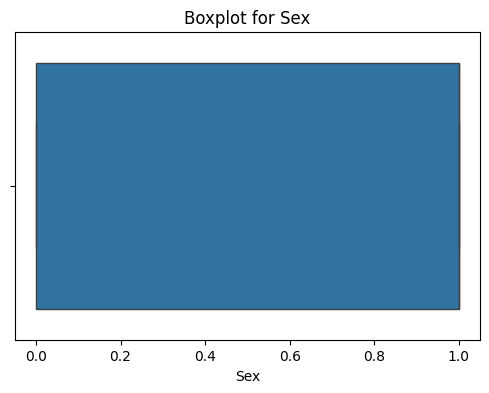

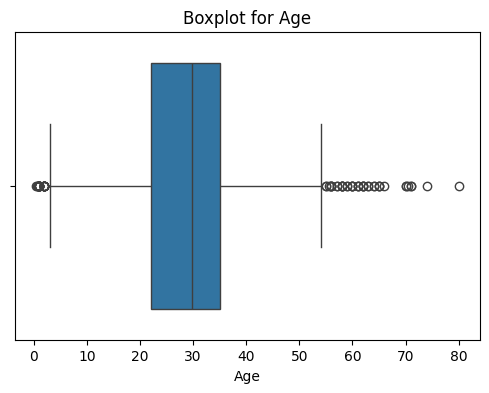

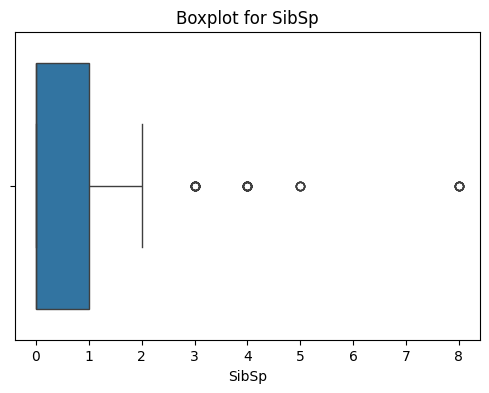

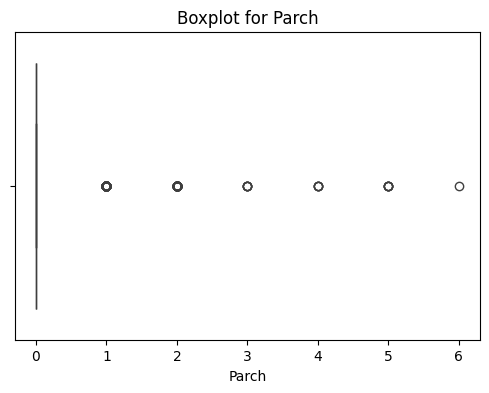

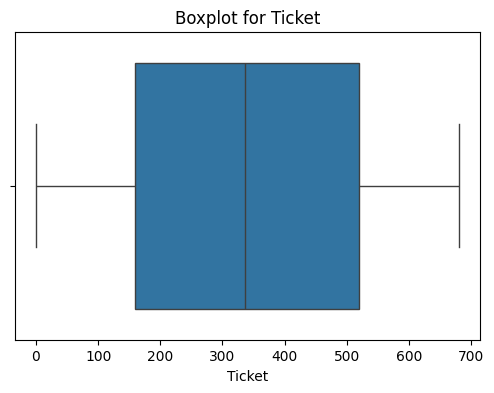

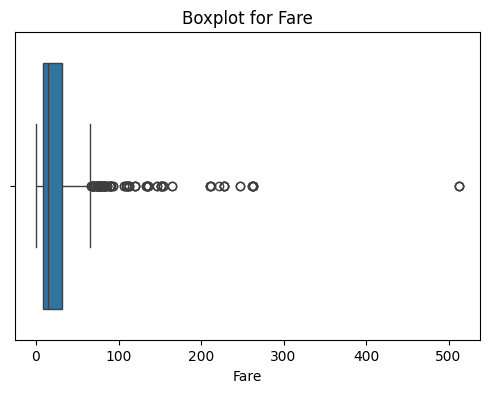

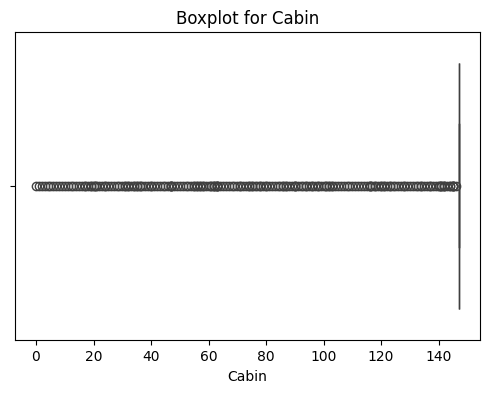

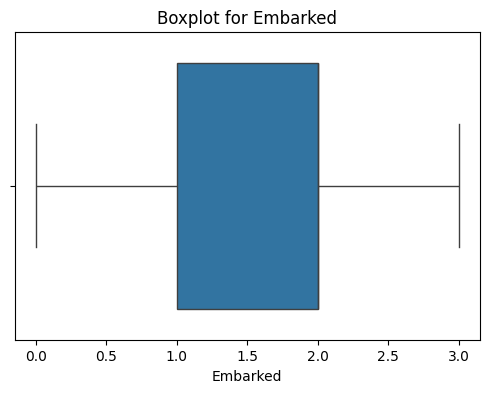

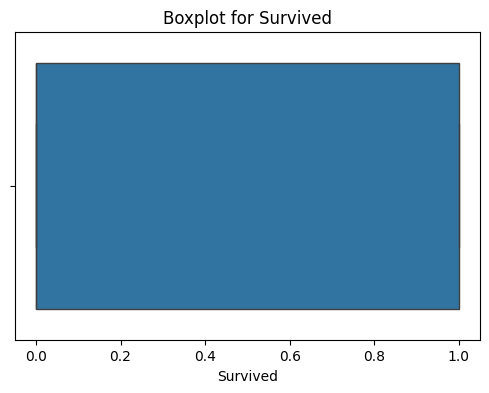

In [12]:
data.columns = data.columns.str.strip()
numeric_columns = data.select_dtypes(include=[np.number]).columns
for col in numeric_columns:
    plt.figure(figsize=(6, 4))  
    sns.boxplot(x=data[col])    
    plt.title(f"Boxplot for {col}")  
    plt.show()

In [13]:
def handle_outliers_clip(data):
    for col in data.select_dtypes(include=[np.number]).columns:
        Q1 = data[col].quantile(0.25)
        Q3 = data[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        data[col] = data[col].clip(lower=lower_bound, upper=upper_bound)    
    return data

data_no_outliers_clip = handle_outliers_clip(data)
print(data_no_outliers_clip.head())

   PassengerId  Name  Pclass  Sex   Age  SibSp  Parch  Ticket     Fare  Cabin  \
0            1   108       3    1  22.0    1.0      0     523   7.2500    147   
1            2   190       1    0  38.0    1.0      0     596  65.6344    147   
2            3   353       3    0  26.0    0.0      0     669   7.9250    147   
3            4   272       1    0  35.0    1.0      0      49  53.1000    147   
4            5    15       3    1  35.0    0.0      0     472   8.0500    147   

   Embarked  Survived  
0         2         0  
1         0         1  
2         2         1  
3         2         1  
4         2         0  


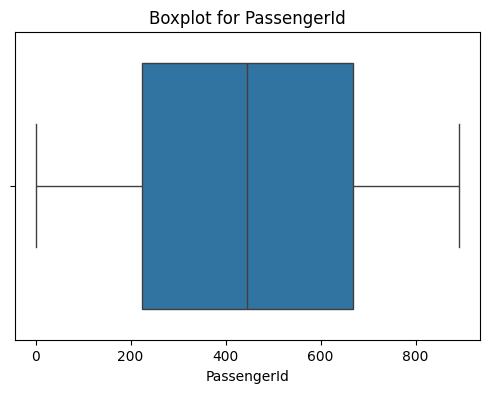

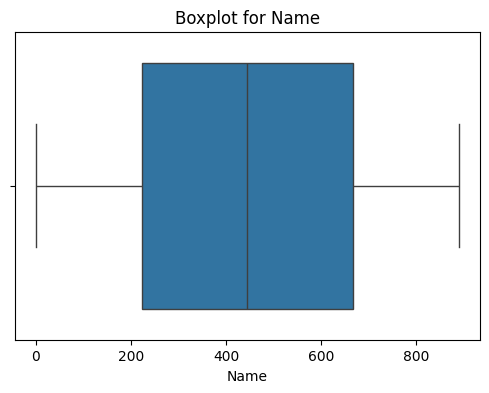

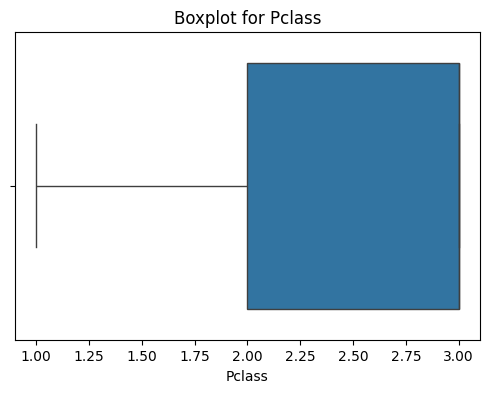

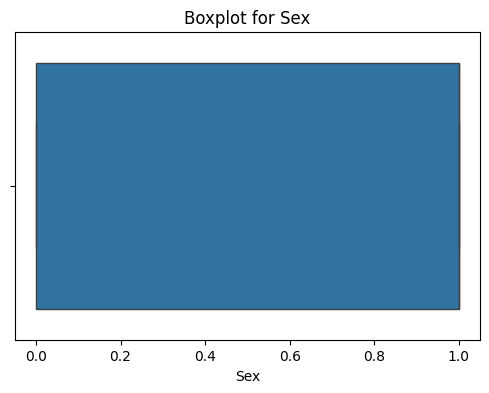

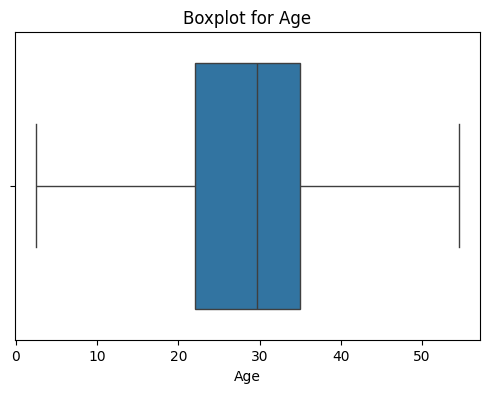

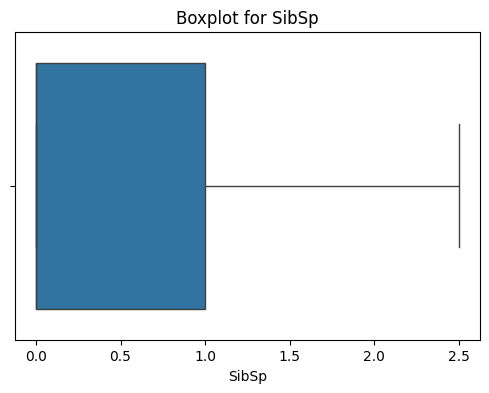

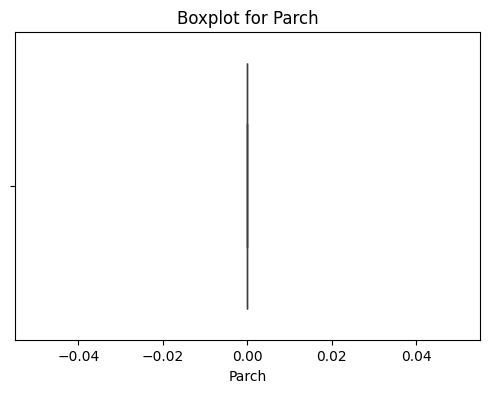

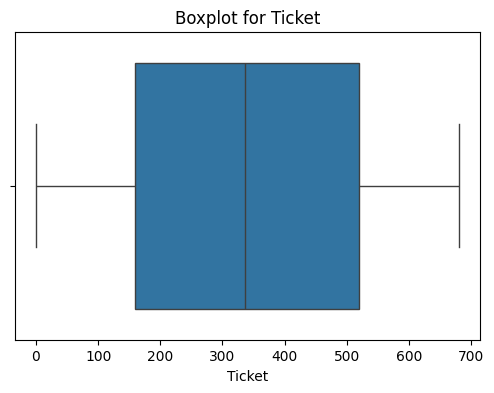

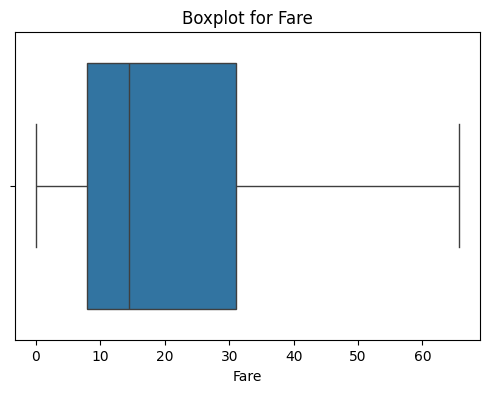

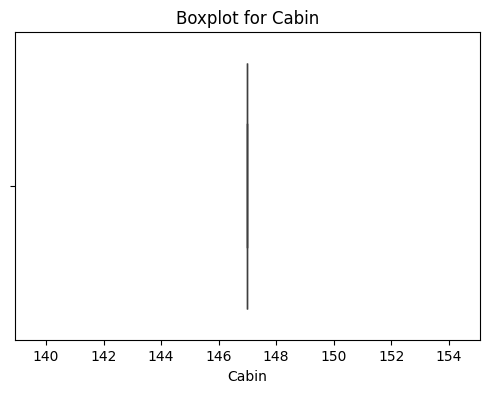

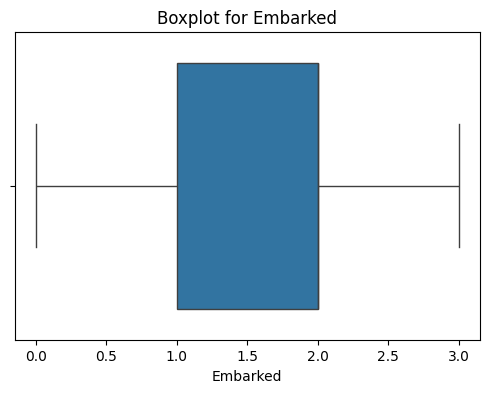

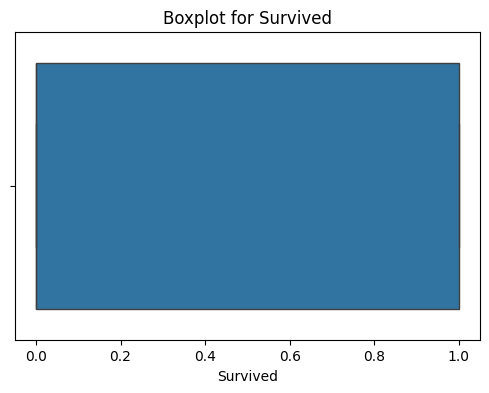

In [14]:
# checking if outliers still exist
data.columns = data.columns.str.strip()
numeric_columns = data.select_dtypes(include=[np.number]).columns
for col in numeric_columns:
    plt.figure(figsize=(6, 4))  
    sns.boxplot(x=data[col])    
    plt.title(f"Boxplot for {col}")  
    plt.show()

### Splitting dataset

In [21]:
# X=data.iloc[:,:-1].values
# y=data.iloc[:,-1]
X = data[['Pclass', 'Sex', 'Age', 'Fare']].values  
y = data['Survived'].values

# Feature scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

### StratifiedKFold

In [22]:
# Initialize StratifiedKFold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Initialize the model
model = LogisticRegression()

# To store accuracy for each fold
accuracies = []

# Perform StratifiedKFold Cross-Validation
for train_index, test_index in skf.split(X_scaled, y):
    # Split the data into training and validation sets for this fold
    X_train_fold, X_test_fold = X_scaled[train_index], X_scaled[test_index]
    y_train_fold, y_test_fold = y[train_index], y[test_index]
    
    # Train the model on the training fold
    model.fit(X_train_fold, y_train_fold)
    
    # Predict on the validation fold
    y_pred_fold = model.predict(X_test_fold)
    
    # Evaluate accuracy for this fold
    accuracy = accuracy_score(y_test_fold, y_pred_fold)
    accuracies.append(accuracy)

# Output the results
print("Accuracies for each fold:", accuracies)
print("Mean accuracy:", sum(accuracies) / len(accuracies))

Accuracies for each fold: [0.7988826815642458, 0.797752808988764, 0.7808988764044944, 0.7696629213483146, 0.797752808988764]
Mean accuracy: 0.7889900194589166


In [19]:
#END